# Optimizing a Model

This page covers:
- `<pipeline>.get_params()` to find parameters in your pipeline to optimize
- Setting up and fitting `GridSearchCV()` to find optimal parameters
- Getting the best model after the grid search via `.best_estimator_` 

```{admonition}
:class: seealso
The [sk-learn](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) docs on hypertuning. 
```

Lets load the data [we've been using.](04e_pipelines) (The code is here but hidden.)

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score


In [2]:
url        = 'https://github.com/LeDataSciFi/data/blob/main/Fannie%20Mae/Fannie_Mae_Plus_Data.gzip?raw=true'
fannie_mae = pd.read_csv(url,compression='gzip').dropna()
y          = fannie_mae.Original_Interest_Rate

# reduce to a different set of vars than the prior pages the slow way
drop = ['Loan_Identifier','Loan_purpose','Origination_Channel', 'Seller_Name', 'Property_type', 'Occupancy_type',
       'Zip_code_short','Product_type','Co-borrower_credit_score_at_origination', 'Mortgage_Insurance_type',
       'Origination_Date', 'First_payment_date','Original_Interest_Rate','UNRATE', 'CPIAUCSL', 'Qdate', 'rGDP', 'TCMR', 'POILWTIUSDM', 'TTLCONS',
       'DEXUSEU', 'BOPGSTB', 'GOLDAMGBD228NLBM', 'CSUSHPISA', 'MSPUS',]
fannie_mae = fannie_mae.drop(drop,axis=1)
fannie_mae = (fannie_mae
              .assign(l_credscore = np.log(fannie_mae['Borrower_Credit_Score_at_Origination']),
                      l_LTV = np.log(fannie_mae['Original_LTV_(OLTV)']),
                     )
             )

# test-train
rng = np.random.RandomState(0) # this helps us control the randomness so we can reproduce results exactly
X_train, X_test, y_train, y_test = train_test_split( fannie_mae , y, random_state=rng)

Let's set up our model. For simplicity, this model just imputes missing values of (all) numerical variables and then OneHotEncodes the state variable. Here is 

In [3]:
preproc_pipe = ColumnTransformer(  
    [ # new here: make_column_selector grabs all columns of a type
    ("num_impute",SimpleImputer(), make_column_selector(dtype_include=np.number)),
    ("cat_trans", OneHotEncoder(drop='first'), ['Property_state'])
    ]
    , remainder = 'drop' 
)

ridge_pipe = make_pipeline(preproc_pipe,Ridge(1.0,
                                              tol=1e-10))
# A "technical" point on "tol" is hidden below

In [4]:
# it turns out that the tolerance setting matters a lot! 
# the default tolerance (1e-3) is not enough to allow the estimator to find improvements here
# You can see this this way: run r2_score with tol 1e-3 and alpha 1, then alpha 100. 
# You'll get the same results indicating that alpha doesn't change the estimation when the 
# tolerance is weaker (1e-3 isnt as demanding as 1e-10)

Let's use the model and compute its performance. 

In [5]:
ridge_pipe.fit(X_train, y_train)
r2_score(y_test,ridge_pipe.predict(X_test,))

0.31696581904124665

## The hyperparameters of a model

```{note}
How this pipeline estimator performs _depends on parameters for each step, **which we call "hyperparameters" in this context.**_
```

For example, the `Ridge()` model's key parameter is "alpha", and changing it will change its results. But it's not the only parameter that can change the results of this pipeline.

```{warning}
Now, look how many parameters this tiny three-step model (impute, encode, ridge regression) has!
```

In [6]:
ridge_pipe # Pipeline "steps" is a list of tuples: [(name,transformer),(name,transformer),...,(name,estimator)]

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_impute', SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000276C62507C0>),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop='first'),
                                                  ['Property_state'])])),
                ('ridge', Ridge(tol=1e-10))])

```{tip}
Use `<pipename>.get_params()` to figure out the names for parameters that you'll explore with `gridsearchcv()`. I usually copy+paste the names straight off the printout. 
```

In [7]:
ridge_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('num_impute', SimpleImputer(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x00000276C62507C0>),
                                   ('cat_trans', OneHotEncoder(drop='first'),
                                    ['Property_state'])])),
  ('ridge', Ridge(tol=1e-10))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('num_impute', SimpleImputer(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000276C62507C0>),
                                 ('cat_trans', OneHotEncoder(drop='first'),
                                  ['Property_state'])]),
 'ridge': Ridge(tol=1e-10),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer__trans

That's a long list!

So this pipeline has parameters for every function in the pipeline:
- `ColumnTransformer()`'s "remainder" parameter is set above as "drop" (look for `columntransformer__remainder`) but you could have chosen "passthrough"
    - The "columntransformer__remainder" name is: the function (columntransformer), two underscores, then the parameter name
- `SimpleImputer()`'s "strategy" parameter is set above as "mean" (look for `columntransformer__num_impute__strategy`) but you could have chosen "median"
    - The "columntransformer__num_impute__strategy" name is like this because the imputer is nested inside the column transformer (so "columntransformer" is before the impute with two underscores), and when I created `preproc_pipe`, I called the imputation step "num_impute"
- `OneHotEncoder()`'s "drop" parameter is set to `None`
- `Ridge()`'s "alpha" is set to 1.0. 




## Tuning hyperparameters

The basic idea is to repeatedly run the pipeline through a cross-validation while changing the hyperparameters to improve your CV scores.

To use GridSearchCV

1. Set up your parameter grids (all of the parameters you would like to test). 
    - **Initially, cast a wide and sparse net.** 
    - After running it once, we can run it again with more parameter values in the regions that we think the best model is in.
    - We will iterate on this, and repeat as needed...
1. Set up GridSearchCV
1. Get the search results by fitting GridSearchCV
    - I like to visualize my CV scores on a y-axis and the parameters on the X-axis so that I know I'm at the global maximum. Just because you're at the top of a hill doesn't mean you're at the top of Everest. In math terminology, you don't want to find the local maximum, you want the global maximum:
    ```{image} ./img/localmax.png
    :alt: localmax
    :width: 300px
    :align: center
    ```
1. Examine the output
1. Save the best parameters

Let's optimize alpha and the imputation method.

<AxesSubplot:title={'center':'CV score by alpha'}, xlabel='alpha'>

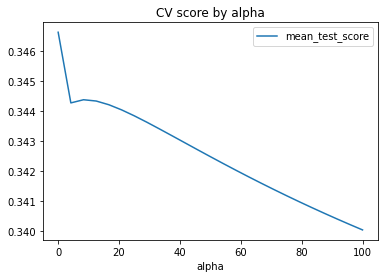

In [8]:
# 1. Set up your parameter grids (all of the parameters you would like to test). 

alphas = list(np.linspace(0.0001,100,25)) # cast net wide and sparse (only 25 points)
strats = ['mean','median']
parameters = {'ridge__alpha': alphas,
              'columntransformer__num_impute__strategy':strats
             }

# 2. Set up GridSearchCV

grid_search = GridSearchCV(estimator = ridge_pipe, 
                           param_grid = parameters,
                           cv = 5) # some folds with whatever the default is (look it up!)

# 3. Get the search results by fitting GridSearchCV

results = grid_search.fit(X_train,y_train)
                           
# 4. Examine the output

results_df = pd.DataFrame(results.cv_results_).set_index('params')
# extract alpha from the params variable
results_df['alpha'] = [c['ridge__alpha'] for c in results_df.index]
results_df = results_df.sort_values('alpha')
results_df.plot(x='alpha',y='mean_test_score',kind='line',
                title='CV score by alpha')

# 5. Save the best parameters

# (It's not time - this graph below doesn't look optimized, go 
# more to the left!)

Clearly, the maximum is a very small alpha...

In [9]:
alphas = list(np.linspace(0.000001,0.0001,25))


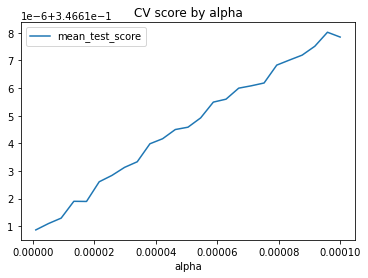

In [10]:
# 1. Set up your parameter grids (all of the parameters you would like to test). 

strats = ['mean','median']
parameters = {'ridge__alpha': alphas,
              'columntransformer__num_impute__strategy':strats
             }

# 2. Set up GridSearchCV

grid_search = GridSearchCV(estimator = ridge_pipe, 
                           param_grid = parameters,
                           cv = 5) # some folds with whatever the default is (look it up!)

# 3. Get the search results by fitting GridSearchCV

results = grid_search.fit(X_train,y_train)
                           
# 4. Save the best parameters

results_df = pd.DataFrame(results.cv_results_).set_index('params')
# extract alpha from the params variable
results_df['alpha'] = [c['ridge__alpha'] for c in results_df.index]
results_df['strat'] = [c['columntransformer__num_impute__strategy'] for c in results_df.index]

results_df = results_df.sort_values('alpha')
results_df.plot(x='alpha',y='mean_test_score',kind='line',
                title='CV score by alpha')

# 5. Save the best parameters

best_ridge = results.best_estimator_ # saves the best gridsearch model 


You should examine performance as a function of the other params in your gridsearch too, but here, there are no missing values in the original data of X, so the imputation choice didn't matter!



## Using tuned parameters

So how did we do? We improved from 0.317 to 0.322, a 1.6% improvement for not much work!

In [11]:
best_ridge.fit(X_train,y_train)      # train
r2_score(y_test,best_ridge.predict(X_test,)) # examine out of sample


0.3222479317272854